In [309]:
import os
from dotenv import load_dotenv
import sqlalchemy
import pandas as pd
import numpy as np
import datetime as dt
from lifetimes import BetaGeoFitter, GammaGammaFitter
import matplotlib.pyplot as plt

In [310]:
# load from .env file
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

load_dotenv(f'{parent_dir}/.env')

postgres_password = os.getenv('POSTGRES_PASSWORD')
postgres_port_no = os.getenv('POSTGRES_PORT_NO')
host = os.getenv('POSTGRES_HOST')
database = os.getenv('POSTGRES_DB')
user = os.getenv('POSTGRES_USER')

In [311]:
# Create database engine
engine = sqlalchemy.create_engine(f'postgresql://{user}:{postgres_password}@{host}:{postgres_port_no}/{database}')

In [312]:
# function to create df
def create_df(table_name):
    try:
        connection = engine.connect() 
        query = f'''
        SELECT 
            *
        FROM
            {table_name} 
        '''
        
        df = pd.read_sql(query, con=connection)
        return df
    except Exception as e:
        print("An error occurred:", e)
        connection.rollback() 
    finally:
        connection.close()  

def create_full_table():
    full_table = create_df('online_sales')
    tables = {'products': 'product_id',
              'users': 'user_id',
              'ratings': 'product_id'
              }
    for key, value in tables.items():
        df = create_df(key)
        full_table = pd.merge(full_table, df, on=value, how='inner')

    full_table['total_price'] = np.where(
    full_table['Coupon_Status'] == 'Used',
    full_table['Quantity'] * full_table['actual_price'] * (1 - full_table['Discount_pct']),
    full_table['Quantity'] * full_table['actual_price']
    )

    return full_table

### BG-NBD Model (Beta Geometric/Negative Binomial Distribution)

To predict customer lifetime value (CLTV) metrics, specifically the expected purchases for individual customers and the overall expected transactions for the company in the next month.

In [313]:
today_date = dt.datetime(2020, 1, 1)
sales = create_full_table()

cltv_prediction = sales.groupby('user_id').agg({
    'date': [min, max],
    'transaction_id': 'nunique', 
    'total_price': 'sum',
})

cltv_prediction.columns = ['earliest_date', 'latest_date', 'frequency', 'monetary']

cltv_prediction['recency'] = (cltv_prediction['latest_date'] - cltv_prediction['earliest_date']).dt.days
cltv_prediction["monetary"] = cltv_prediction["monetary"] / cltv_prediction["frequency"]
cltv_prediction['T'] = (today_date - cltv_prediction['earliest_date']).dt.days

cltv_prediction = cltv_prediction[(cltv_prediction["frequency"] > 1)]
cltv_prediction = cltv_prediction[(cltv_prediction["recency"] > 0)]

cltv_prediction["T"] = cltv_prediction["T"] / 7
cltv_prediction["recency"] = cltv_prediction["recency"] / 7

cltv_prediction.drop(columns=['earliest_date', 'latest_date'])

sum(cltv_prediction['frequency'])

20144

In [314]:
bgf = BetaGeoFitter(penalizer_coef=0.01)
bgf.fit(cltv_prediction["frequency"], cltv_prediction["recency"], cltv_prediction["T"])

<lifetimes.BetaGeoFitter: fitted with 734 subjects, a: 0.39, alpha: 0.01, b: 3.24, r: 0.28>

In [301]:
# Define number of bootstrap samples
n_bootstrap_samples = 100
bootstrap_results = []

for i in range(n_bootstrap_samples):
    # Sample with replacement
    bootstrap_sample = cltv_prediction.sample(frac=1, replace=True)
    
    # Fit model on bootstrap sample
    bgf.fit(bootstrap_sample["frequency"], bootstrap_sample["recency"], bootstrap_sample["T"])
    
    # Calculate expected transactions for a month
    monthly_pred = bgf.predict(4, bootstrap_sample["frequency"], bootstrap_sample["recency"], bootstrap_sample["T"]).sum()
    bootstrap_results.append(monthly_pred)

# Calculate mean and standard deviation of the bootstrap predictions
bootstrap_mean = np.mean(bootstrap_results)
bootstrap_std = np.std(bootstrap_results)

print(f"Bootstrap Mean Monthly Prediction: {bootstrap_mean}")
print(f"Bootstrap Standard Deviation: {bootstrap_std}")


Bootstrap Mean Monthly Prediction: 423.96542386093716
Bootstrap Standard Deviation: 42.17866598491564


The Bootstrap Mean Monthly Prediction of approximately 430.73 suggests that the model expects around 430 transactions per month across your customer base. The Standard Deviation of about 53.06 indicates some variability in these monthly predictions, but the range (about ±53 transactions) shows a relatively consistent estimate.

In [315]:
# find the top 10 customers who will purchase in the next 1 week
top_customers_next_week = bgf.conditional_expected_number_of_purchases_up_to_time(1,  # number of weeks
                                                        cltv_prediction["frequency"],
                                                        cltv_prediction["recency"],
                                                        cltv_prediction["T"]).sort_values(ascending=False).head(10)
print(f"top 10 customers and their probability of making a purchase in the following week: {top_customers_next_week}")

# number of transactions expected by the company in a month

num_transactions_in_month = bgf.predict(4, cltv_prediction["frequency"], cltv_prediction["recency"], cltv_prediction["T"]).sum()
print(f"Expected number of transactions in the next month: {num_transactions_in_month}")

top 10 customers and their probability of making a purchase in the following week: user_id
16745    6.456722
14606    5.744318
14438    4.859122
15808    2.725777
17315    1.815389
13488    1.641037
14462    1.545121
13050    1.471981
14085    1.454911
13069    1.454297
dtype: float64
Expected number of transactions in the next month: 423.59670986734284


### Gamma-Gamma Model

In [316]:
ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(cltv_prediction["frequency"], cltv_prediction["monetary"])

# Find average profit
ggf.conditional_expected_average_profit(cltv_prediction["frequency"], cltv_prediction["monetary"])
cltv_prediction["expected_average_profit"] = ggf.conditional_expected_average_profit(cltv_prediction["frequency"], cltv_prediction["monetary"])

cltv = ggf.customer_lifetime_value(bgf,
                                   cltv_prediction["frequency"],
                                   cltv_prediction["recency"],
                                   cltv_prediction["T"],
                                   cltv_prediction["monetary"],
                                   time=3, # 3 months, how many months account do you want?
                                   freq="W", # frequency information of T
                                   discount_rate=0.01)
cltv = cltv.reset_index()
cltv_final = cltv_prediction.merge(cltv, on="user_id", how="left")
cltv_final.sort_values(by="clv", ascending=False).head(10)


,user_id,earliest_date,latest_date,frequency,monetary,recency,T,expected_average_profit,clv
111,13113,2019-04-04,2019-12-24,29,24929.621552,37.714286,38.857143,25115.694397,222131.088622
276,14606,2019-01-16,2019-12-31,289,1284.894374,49.857143,50.000000,1285.861324,90455.469697
185,13842,2019-03-28,2019-12-19,18,14303.309056,38.000000,39.857143,14476.177402,76956.581950
149,13488,2019-03-21,2019-12-20,76,3710.808882,39.142857,40.857143,3721.366677,74224.701194
253,14438,2019-12-30,2019-12-31,5,1809.170200,0.142857,0.285714,1891.048718,59444.243622
526,16745,2019-12-06,2019-12-30,28,816.516071,3.428571,3.714286,822.946542,50731.609621
195,13963,2019-03-19,2019-12-26,16,10266.794125,40.285714,41.142857,10406.658909,48575.865542
420,15808,2019-02-22,2019-12-30,123,1301.848967,44.428571,44.714286,1304.152839,43355.316637
225,14180,2019-01-23,2019-12-16,41,4106.064049,46.714286,49.000000,4127.762891,39853.339013
536,16814,2019-02-14,2019-12-16,36,3615.957361,43.571429,45.857143,3637.747305,32887.589020


In [304]:
# Custom bin ranges
bins = [0, 500, 1000, 10000, float('inf')]
labels = ["Low", "Medium", "High", "Top"]

# Segment based on custom bins
cltv_final['clv_segment'] = pd.cut(cltv_final['clv'], bins=bins, labels=labels)
print(cltv_final[['user_id', 'clv', 'clv_segment']])

     user_id           clv clv_segment
0      12347  1.908465e+02         Low
1      12348  4.363231e+03        High
2      12370  3.250934e-32         Low
3      12377  3.865907e+02         Low
4      12383  9.388449e-10         Low
..       ...           ...         ...
729    18239  6.428863e+03        High
730    18245  2.998248e+02         Low
731    18260  1.042154e+00         Low
732    18269  1.284440e+02         Low
733    18283  3.716781e-12         Low

[734 rows x 3 columns]


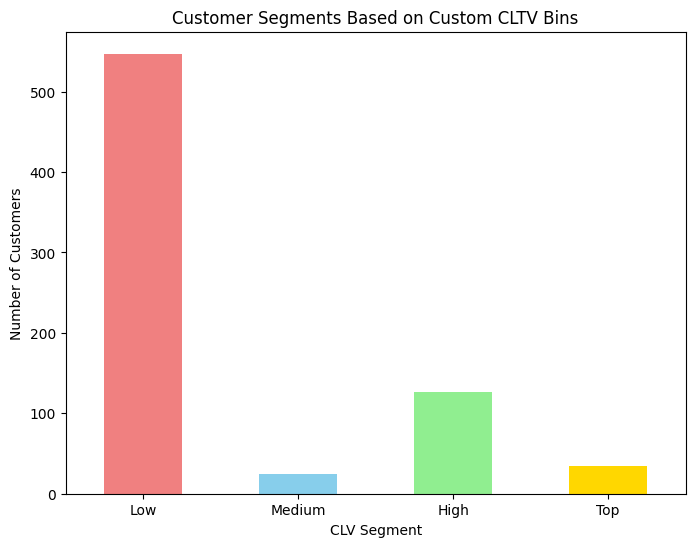

In [305]:
# Define custom bin ranges and labels
bins = [0, 500, 1000, 10000, float('inf')]
labels = ["Low", "Medium", "High", "Top"]

# Segment based on custom bins
cltv_final['clv_segment'] = pd.cut(cltv_final['clv'], bins=bins, labels=labels)

# Count the number of customers in each segment
segment_counts = cltv_final['clv_segment'].value_counts().reindex(labels)

# Plot the segments
plt.figure(figsize=(8, 6))
segment_counts.plot(kind='bar', color=['lightcoral', 'skyblue', 'lightgreen', 'gold'])
plt.title("Customer Segments Based on Custom CLTV Bins")
plt.xlabel("CLV Segment")
plt.ylabel("Number of Customers")
plt.xticks(rotation=0)
plt.show()

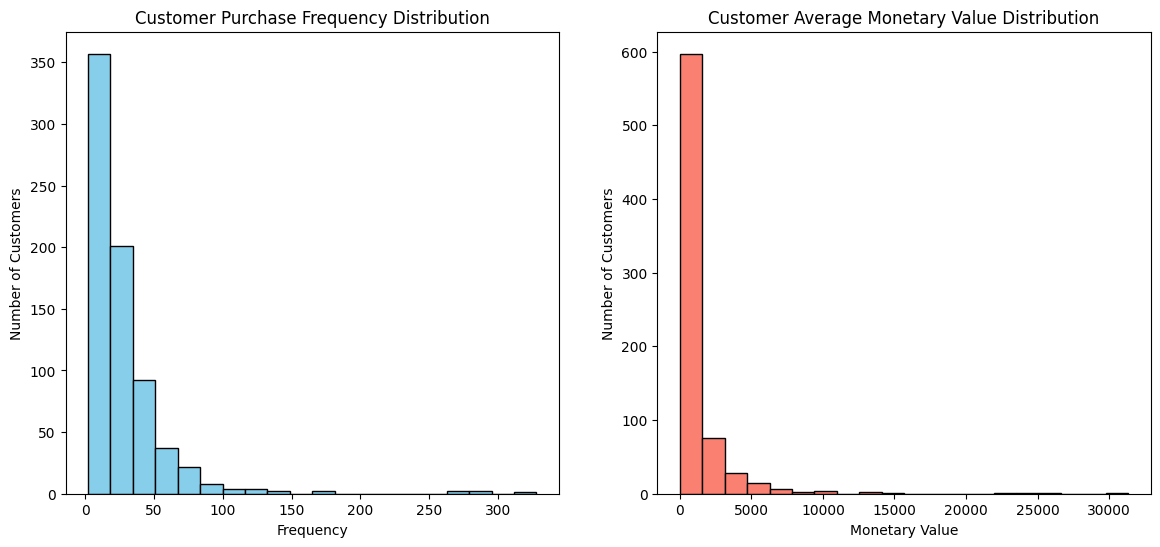

In [306]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.hist(cltv_prediction['frequency'], bins=20, color='skyblue', edgecolor='black')
ax1.set_title("Customer Purchase Frequency Distribution")
ax1.set_xlabel("Frequency")
ax1.set_ylabel("Number of Customers")

ax2.hist(cltv_prediction['monetary'], bins=20, color='salmon', edgecolor='black')
ax2.set_title("Customer Average Monetary Value Distribution")
ax2.set_xlabel("Monetary Value")
ax2.set_ylabel("Number of Customers")

plt.show()


/Users/delphineloke/Desktop/Passion8/.venv/lib/python3.12/site-packages/lifetimes/fitters/beta_geo_fitter.py:256: RuntimeWarning: overflow encountered in scalar power
  denominator = 1 + (x > 0) * (a / (b + x - 1)) * ((alpha + T) / (alpha + recency)) ** (r + x)


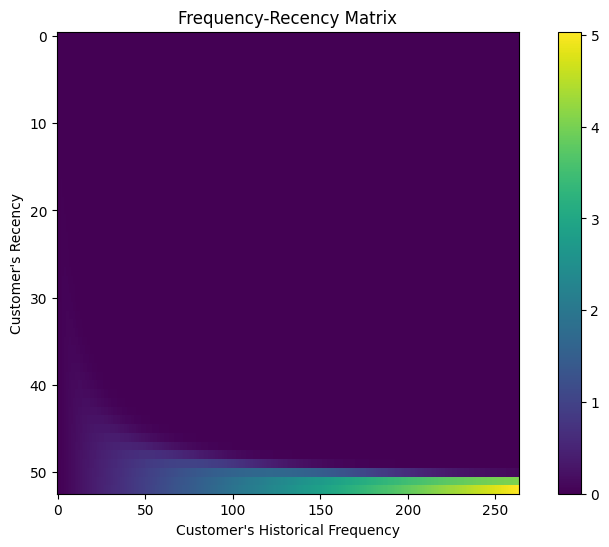

In [307]:
from lifetimes.plotting import plot_frequency_recency_matrix
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plot_frequency_recency_matrix(bgf)
plt.title("Frequency-Recency Matrix")
plt.show()


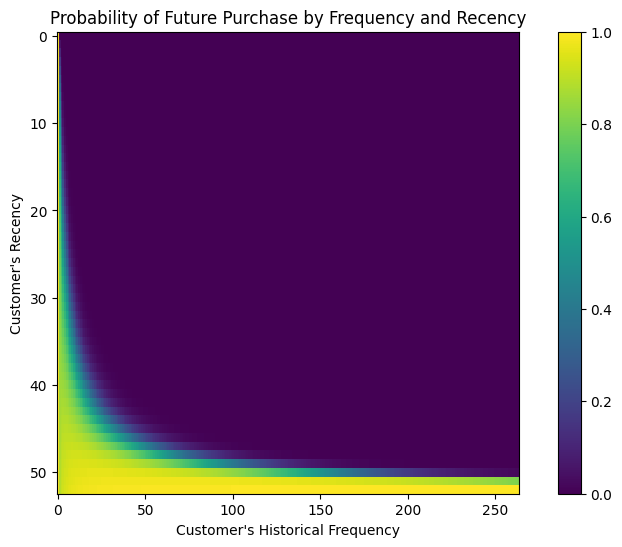

In [308]:
from lifetimes.plotting import plot_probability_alive_matrix

plt.figure(figsize=(10, 6))
plot_probability_alive_matrix(bgf)
plt.title("Probability of Future Purchase by Frequency and Recency")
plt.show()

# Evaluation against CLTV Calculation

Predictive CLTV models, like BG/NBD and Gamma-Gamma, are typically conservative and assume that not all customers will continue to purchase at the same frequency or value as they have historically hence, the predicted CLTV is often lower than the actual calculated CLTV.  

Predictive CLTV models usually assume a degree of customer churn and purchase decay, meaning that over time, some customers will stop purchasing, and the frequency or value of purchases may decrease.  

For instance, the BG/NBD model incorporates probabilities of "dropout" for each customer, inherently leading to more conservative CLTV predictions.  

Additionally, with limited historical data or low-frequency customers, predictive models have less data to accurately estimate long-term behavior, often resulting in conservative (lower) predictions.  

Models prioritize repeat purchasing behavior, which often reduces predicted CLTV for customers with sporadic or low-frequency purchases.